In [2]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Ejemplo numérico

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas y el objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_0,b_1, b_2,...,b_{n_b}]^T$.

$$y[k] = -a_1y[k-1]-...-a_{n_a}y[k-{n_a}] + b_0u[k]+b_1u[k-1]+...+b_{n_b}u[k-{n_b}] + L + e[k]$$

Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[t] = \phi.\theta + e[t]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k]&u[k-1]&...&u[k-{n_b}]&1\end{bmatrix}$$


## Ejemplo 1

Se mide la salida de un sistema dinámico y se almacena en la señal $y_N$

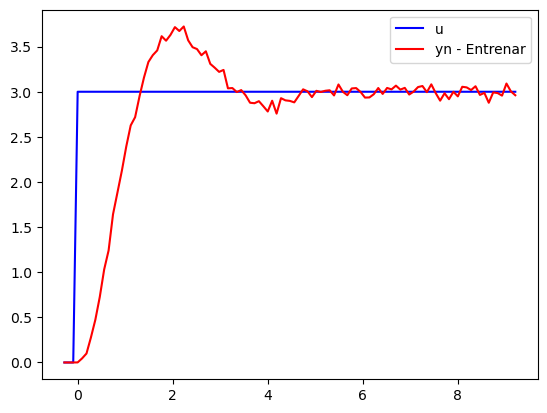

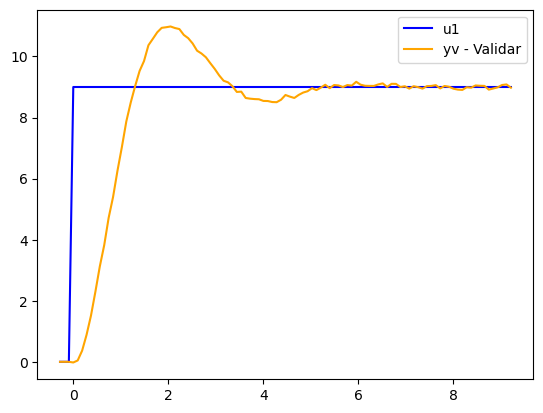

In [8]:
## Sistema de segundo orden en tiempo continuo
K1 = np.random.randint(2,5,dtype=int)
g = control.tf(6,[2,3,6])
t,y = control.step_response(K1*g)
N = len(y)
u = K1*np.ones(N);
dt = (t[1]-t[0])

## Generando los datos de validación
K2 = np.random.randint(6,12,dtype=int)
_,yv = control.step_response(K2*g,t)

## Señal de entrenamiento RUIDOSA
r = 0.05
e1 = np.random.normal(0,r,size=N)
yn = y+e1

## Señales de validación RUIDOSA
e2 = np.random.normal(0,r,size=N)
yv = yv+e2
u1 = K2*np.ones(N);

## Insertando datos para el cambio de estado de las entradas
## Actualizando tamaño de listas

t = np.array([-3*dt, -2*dt, -dt] + list(t))
u = np.array([0.0]*3 + list(u))
u1 = np.array([0.0]*3 + list(u1))
yv = np.array([0.0]*3 + list(yv))
yn = np.array([0.0]*3 + list(yn))
N = len(yn)

plt.plot(t,u,color = 'blue')
plt.plot(t,yn,color = 'red')
plt.legend(["u","yn - Entrenar"])
plt.figure()
plt.plot(t,u1,color = 'blue')
plt.plot(t,yv,color = 'orange')
plt.legend(["u1","yv - Validar"])

## Definir la matriz de regresión - Entrenamiento del modelo

Recordar que la matriz de regresión o regresor contiene la hipótesis frente a lo que se espera del modelo a estimar, por tanto se debe reflexionar alrededor de qué incluir en el regresor.

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&...&u[k-{n_b}]\end{bmatrix}$$

In [37]:
## Definir y_1, y_2, y_3, dependiendo de su HIPÓTESIS
## del sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
y_4 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=yn[k-3]
    u_3[k]=u[k-3]
for k in range(4,N):
    y_4[k]=yn[k-4]
    
    
## Creación de la hipótesis
phi = np.array([-y_1,-y_2,-y_3,-y_4,u_1,u_3]).transpose()

## Calculando los parámetros del modelo planteado en el regresor
$$\theta_{ls} = \phi^+.y[k]$$

La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad.

In [38]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
alpha = 0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.74107636, -0.52110097, -0.04895514,  0.38922569,  0.01835571,
        0.06076418])

## Reconstruyendo la señal con la ecuación en diferencia obtenida:

A partir del regresor el modelo o la ecuación en diferencia estaría dada por:

$$y_e[k] = a_1y[k-1] +...+ a_{n_a}y[k-{n_a}] + b_0u[k]+ b_1u[k-1]+...+b_{n_b}u[k-{n_b}] + C_1$$

Donde C1, es el parámetro de ajuste obtenido:

$$y_e[k] = -0.827y[k-1]-0.4708y[k-2]-0.06552y[k-3]+0.4182y[k-4]+ 0.0055u[k]+0.04958u[k-1]$$

Esta reconstrucción es sencilla de obtener una vez calculados los parámetros puesto que simplemente dentro del código se debe realizar:

$$y_e[k] = \phi*\theta$$

## Validando el modelo obtenido usando datos para validar

Para validar el modelo se utilizarán los datos de validación guardados en la señal $y_V$ cuya entrada fue de magnitud ALEATORIA durante la medición. El proceso para reconstruir una señal a partir de los parámetros y usando la ec. en diferencia es:

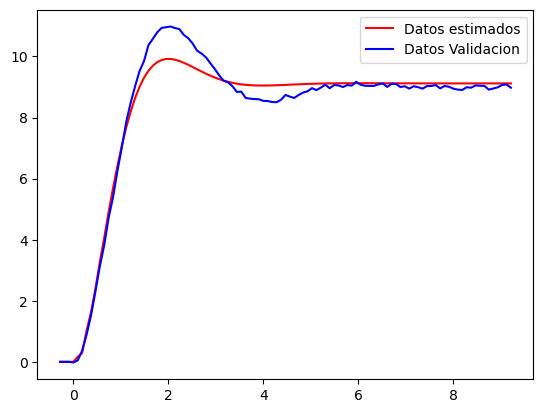

In [40]:
### Modelo 
### y_e = -y_1,-y_2,-y_3,-y_4,u_1,u_2
ye1 = np.zeros(N);

for k in range(3,N):
    ye1[k] = -theta[0]*ye1[k-1]-theta[1]*ye1[k-2]-theta[2]*ye1[k-3]-theta[3]*ye1[k-4]+theta[4]*u1[k-1]+theta[5]*u1[k-3]  
    
plt.plot(t,ye1,color = 'red')
plt.plot(t,yv,color = 'blue')
plt.legend(["Datos estimados", "Datos Validacion"])

## Armando la Función de Transferencia B/A

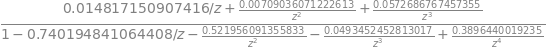

In [30]:
## Construyendo las funciones G y H    y(k) = G(z)u(k) + H(z)e(k)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)
## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2 + theta[2]*z**-3 + theta[3]*z**-4
B = theta[4]*z**-1+theta[5]*z**-2+theta[6]*z**-3
G = B/A
#G = G.simplify()
H = 1/A
H = H.simplify()
G

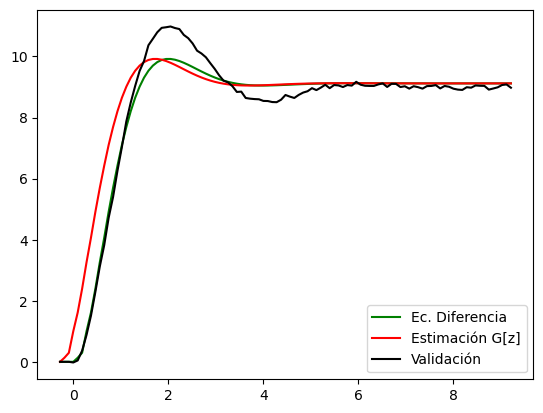

In [31]:
## Intento 1 - respuesta discreta.
## Ensayar con nuevos dt
G_e = control.tf([theta[4],theta[5],theta[6],0],[1,theta[0],theta[1],theta[2],theta[3]],dt)

## Se usa la ganancia K2 por tomando datos de validación
_,ye = control.step_response(K2*G_e,t)

plt.plot(t,ye1,color = 'green')
plt.plot(t,ye,color = 'red')
plt.plot(t,yv,color = 'black')
plt.legend(['Ec. Diferencia','Estimación G[z]','Validación'])

## Función de transferencia obtenida

Se imprime la $G_e$ resultante del cálculo. También se determinan los parámetros comparativos ECM y R2

In [32]:
## Función de transferencia G(z)
print(G_e)
### ECM
e1 = yv-ye1
ECM = np.dot(e1.transpose(),e1)/len(e1)
R2 = 1 - np.dot(e1.transpose(),e1)/np.dot(yv.transpose(),yv)
ECM, R2

<TransferFunction>: sys[60]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      0.01482 z^3 + 0.00709 z^2 + 0.05727 z
-------------------------------------------------
z^4 - 0.7402 z^3 - 0.522 z^2 - 0.04935 z + 0.3896

dt = 0.09303374113107254



array([[list([<matplotlib.lines.Line2D object at 0x00000256CA405870>]),
        list([<matplotlib.lines.Line2D object at 0x00000256CA4065F0>])]],
      dtype=object)

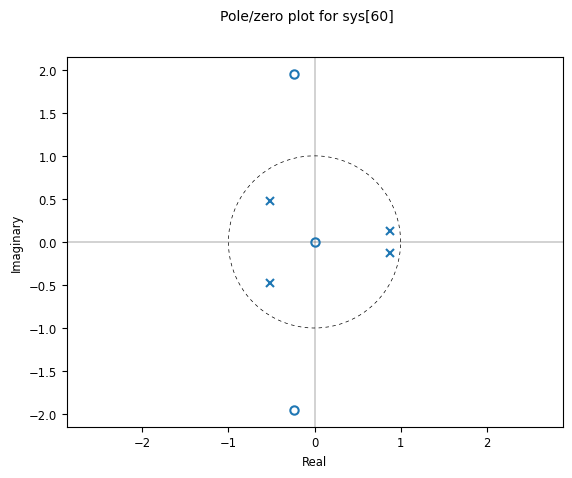

In [33]:
control.pzmap(G_e)